In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from scipy import interpolate
from scipy.spatial import ConvexHull


def plot(df, y_column, ax, colors):
    for i in df[y_column].unique():
        if i == -1:
            dff = df[df[y_column]==i]
            ax.scatter(dff['x1'], dff['x2'], c='r', alpha = 0.9, s=30)
            continue

        # get the convex hull
        points = df[df[y_column] == i][['x1', 'x2']].values
        hull = ConvexHull(points)
        x_hull = np.append(points[hull.vertices,0],
                           points[hull.vertices,0][0])
        y_hull = np.append(points[hull.vertices,1],
                           points[hull.vertices,1][0])

        # interpolate
        dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
        dist_along = np.concatenate(([0], dist.cumsum()))
        spline, u = interpolate.splprep([x_hull, y_hull], 
                                        u=dist_along, s=0)
        interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
        interp_x, interp_y = interpolate.splev(interp_d, spline)
        # plot shape
        try:
            ax.fill(interp_x, interp_y, '--', c=colors[i], alpha=0.25)
            dff = df[df[y_column]==i]
            ax.scatter(dff['x1'], dff['x2'], c=colors[i], alpha = 0.7, s=60,edgecolors='k')
        except IndexError:
            raise IndexError('Add more colors to colors list.')

Predicted anomalies size = 69
[               x1           x2  y_true  y_pred
21    1150.402976  1180.177930       0      -1
178   1148.197731  1132.598608       3      -1
183   1128.775115  1198.181811       2      -1
205   1129.066078  1193.251698       2      -1
258   1150.044231  1179.791797       0      -1
...           ...          ...     ...     ...
3153  1189.436280  1103.198969       1      -1
3254  1149.386997  1129.808837       3      -1
3260  1133.721935  1198.026610       2      -1
3332  1148.402237  1130.658044       3      -1
3455  1149.548659  1179.293809       0      -1

[69 rows x 4 columns]]


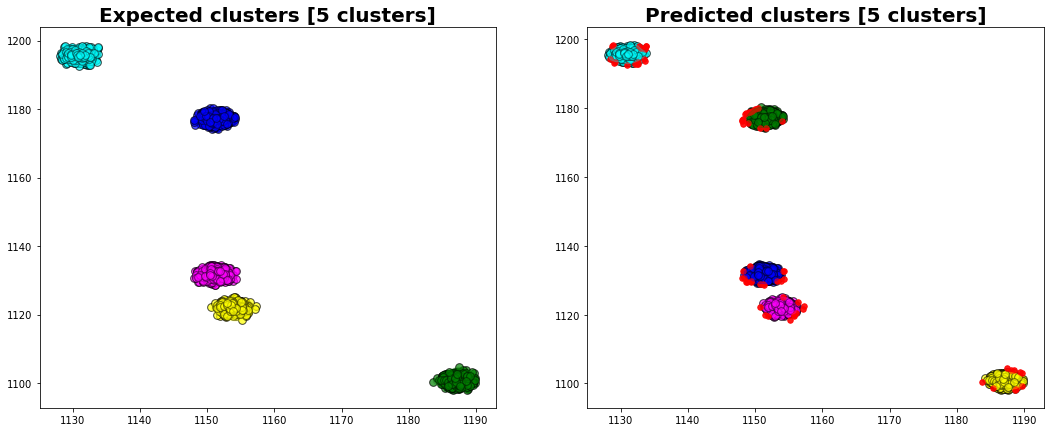

In [41]:
X, y_true = make_blobs(
    n_samples=3461,
    n_features=2, 
    centers=5, 
    center_box=(1100, 1200), 
    random_state=random_seed
)

f = open("data.csv", "w")
for row in range(len(X[:,0])):
  writeStr = '{};{};{}\n'.format(X[row,0], X[row,1], y_true[row])
  f.write(writeStr)

f.close()

df = pd.DataFrame(
    data={
        'x1':X[:,0],
        'x2':X[:,1],
        'y_true':y_true
    }
)


df['y_pred'] = DBSCAN(eps=1.5, min_samples=120, metric='manhattan').fit_predict(df[['x1','x2']])
anomalies = []
for i in df['y_pred'].unique():
  if i == -1:
    anomalies.append(df[df['y_pred']==i])
if len(anomalies) > 0:
  print("Predicted anomalies size = %d\n%s" % (len(anomalies[0]), anomalies))

df.head()

# створюємо картинку з двома графіками всередині
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18, 7))
# визначаємо кольори (при помилці "Add more colors to colors list." потрібно додавити кольори до списку кольорів)
colors = ['blue','green','cyan','magenta','yellow','orange','lime','grey','indigo','gold']


ax1.set_title(f'Expected clusters [{len(df["y_true"].unique())} clusters]', fontweight="bold", fontsize=20)
plot(df, 'y_true', ax1, colors)

ax2.set_title(f'Predicted clusters [{len(df["y_pred"].unique()) - 1} clusters]', fontweight="bold", fontsize=20)
plot(df, 'y_pred', ax2, colors)